### Sea Surface Temperature (SST) from satellite data

Daily L3-gridded (0.02$^\circ$) SST data can be downloaded via the IMOS data portal (https://researchdata.edu.au/imos-srs-sst-time-australia/1370442?source=suggested_datasets)

In [19]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import gsw

%matplotlib inline

plt.rcParams['font.size'] = '13'

In [ ]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

In [2]:
import src.importData as imports
import imp
import src.maps as maps
import src.settings as settings
import src.calc as calc
import src.interpolation as interp
import src.concat as ct
import src.plots as plots
import src.stats as stats

In [3]:
# path to figures
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter1_manuscript', 'revision_figures')

In [4]:
floatids = [8489, 8492, 8493]
ema = imports.importFloatData(floatids)

floatid = 8493
float_num = ema[floatid]
rs = calc.findRSperiod(float_num)

# SST
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
sst_ds_0_02 = imports.importNetCDF(datadir, 'IMOS_aggregation_20220923T013201Z.nc', datatype ='sst')
sst = sst_ds_0_02.rename({'lat':'latitude', 'lon':'longitude'})
sst_deg = sst.sea_surface_temperature - 273.15

# Okubo-Weiss
ow = imports.importNetCDF(datadir, 'okubo_weiss.nc', datatype ='altimetry').okubo_weiss

# SSH
alt_cmems = imports.importNetCDF(datadir, 'cmems_mr.nc', datatype ='altimetry')

# FLSE
ds = imports.importNetCDF(datadir, 'FSLE.nc')
fsle = ds.rename({'lat':'latitude', 'lon':'longitude'}).fsle_max

# EKE
EKE = calc.calcEKE(float_num, floatid, alt_ds = alt_cmems, altimetry = True, interp_to_flt = False)

mean u and v between 2016-10-21 and 2019-10-21


In [5]:
sst

<xarray.Dataset>
Dimensions:                  (latitude: 500, longitude: 1500, time: 273)
Coordinates:
  * latitude                 (latitude) float32 -50.01 -50.03 ... -59.97 -59.99
  * longitude                (longitude) float32 145.0 145.0 ... 175.0 175.0
  * time                     (time) datetime64[ns] 2018-10-14T09:20:00 ... 20...
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 nan nan ... nan
    sst_dtime                (time, latitude, longitude) float32 ...
    dt_analysis              (time, latitude, longitude) float32 ...
    satellite_zenith_angle   (time, latitude, longitude) float32 ...
    l2p_flags                (time, latitude, longitude) float32 ...
    quality_level            (time, latitude, longitude) float32 ...
    sses_bias                (time, latitude, longitude) float32 ...
    sses_standard_deviation  (time, latitude, longitude) float32 ...
    sses_count               (time, latitude, longitude) float32 ...
Attributes: (12/47)
    title:                      IMOS L3S Day and Night gridded multiple-senso...
    summary:                    Skin sea surface temperature retrievals from ...
    references:                 http://imos.org.au/sstproducts.html and Griff...
    institution:                ABOM
    comment:                    Multi-sensor L3S retrievals produced by the A...
    license:                    GHRSST protocol describes data use as free an...
    ...                         ...
    publisher_url:              http://www.ghrsst.org
    processing_level:           L3S
    cdm_data_type:              grid
    history:                    platform_counts=NPP=2;MetOpB=2;NOAA-18=2,qual...
    Conventions:                CF-1.6
    acknowledgment:             Any use of these data requires the following ...

In [6]:
# Triaxus
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'triaxus')
folder = 'in2018_v05CtdAvgTriaxus_VerticalCasts_nc'

tow_list = ['04_002']

triaxus_cast = imports.triaxus_data(datadir, tow_list, folder)
tow = triaxus_cast['04_002']

In [29]:
start = float_num.time.values[0] - np.timedelta64(7, 'D')
end = float_num.time.values[-1]

start_time, end_time = str(start.astype('M8[D]')), str(end.astype('M8[D]'))
sst_sel = sst_deg.sel(time = slice(start_time, end_time), longitude = slice(145, 165))
adt = alt_cmems.adt.sel(time = slice(start_time, end_time), longitude = slice(145, 165))

sst_qc = sst.sel(time = slice(start_time, end_time), longitude = slice(145, 165)).quality_level

levels = np.arange(-0.6, 0.4, 0.15)

In [31]:
var = sst_sel

for t in range(len(var)):
    # filter bad data (quality level < 3)
    mask = (sst_qc[t].data < 3)
    var[t].data[mask] = np.nan
     
label = 'SST (\N{DEGREE SIGN}C)'
cmap = 'plasma'
vmin, vmax = 1, 8.5
extend = 'both'
lons = slice(148,156)
lats = slice(-51,-57)
latmin, latmax = -51, -57

In [10]:
floatid = 8493
float_num = ema[floatid]
dist = calc.cum_dist(float_num.longitude, float_num.latitude)
rs = calc.findRSperiod(float_num)

d1, d2 = 260,330
i_1 = stats.find_nearest(dist, d1)[0]
i_2 = stats.find_nearest(dist, d2)[0]

start = float_num.time[i_1].values
end = float_num.time[i_2].values

start_time, end_time = str(start.astype('M8[D]')),  str(end.astype('M8[D]'))
sst_sel = var.sel(time = slice(start_time, end_time), latitude = slice(latmin, latmax), longitude = slice(148,155))

sst_qc = sst.sel(time = slice(start_time, end_time), 
                      latitude = slice(latmin, latmax), 
                      longitude = slice(148,155)).quality_level


Text(0.5, 1.0, 'EM-8493')

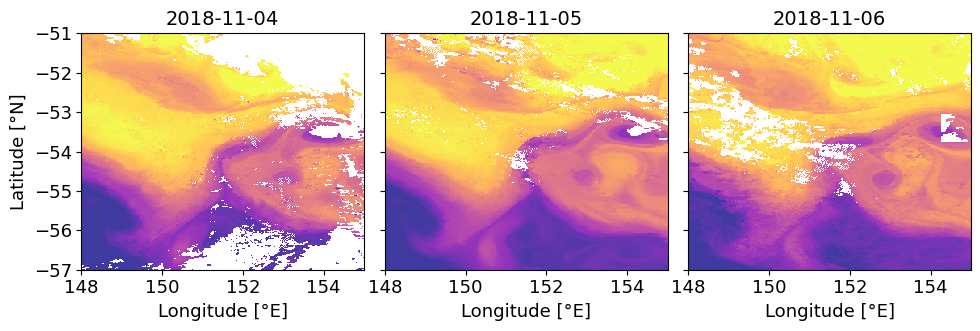

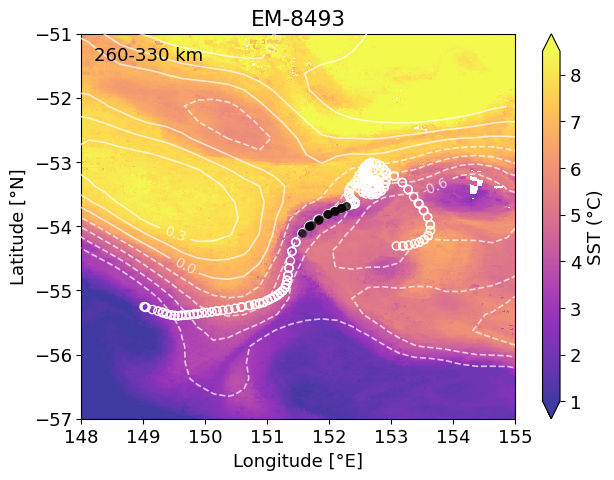

In [22]:
fig, axs = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (10,3.5))
axs = axs.flatten()
for t in range(len(sst_sel)):
    
    # filter bad data (quality level < 3)
    mask = (sst_qc[t].data < 3)
    sst_sel[t].data[mask] = np.nan

    sst_sel[t].plot(ax = axs[t], vmin = vmin, vmax = vmax, alpha = 0.8, cmap = cmap, add_colorbar = False)
    
    axs[t].set_title(str(sst_sel[t].time.data.astype('M8[D]')), fontsize = 14)
    axs[t].set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
    axs[t].set_ylabel('')
    axs[0].set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')


mean_var = sst_sel.mean(dim = 'time',skipna = True)
msl = alt_cmems.adt.sel(time = slice(start_time, end_time)).mean(dim = 'time')
plt.tight_layout(w_pad = 0.2)


fig, ax = plt.subplots(figsize = (7,5))
mean_var.plot(vmin = vmin, vmax = vmax, alpha = 0.8, cmap = cmap, extend = extend, cbar_kwargs = dict(label = label))

CS = msl.plot.contour(colors = 'w', linewidths = 1.2, levels = levels, alpha = 0.7, zorder = 4)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f', levels = levels[[0,2,4,6]])

plt.scatter(float_num.longitude[rs], float_num.latitude[rs], s = 35, facecolors='none', edgecolors='w', zorder = 4)
plt.scatter(float_num.longitude[i_1:i_2], float_num.latitude[i_1:i_2], s = 30, c='k', alpha = 0.7, zorder = 4)

# plt.plot(tow.longitude, tow.latitude, c = 'dimgrey', linewidth = 2.5, zorder = 5)

# ax.set_title(r'$\bf{EM-{floatid}}$'+ '\n' + start_time + ' - ' + end_time, fontsize = 15)
# ax.set_title(start_time + ' - ' + end_time, fontsize = 15)
ax.text(0.03, 0.93, f'{d1}-{d2} km', transform = ax.transAxes, fontsize = 13, zorder = 5)

ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
ax.set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')
plt.title(f'EM-{floatid}')

In [68]:
# settings.save_figure(fig, my_path, f'SST_{floatid}.png', dpi = 600, pad = 0.2)

In [23]:
mean_var = sst_sel.mean(dim = 'time', skipna = True)
# mean_var = sst_sel[0]

lt = -54.51

ind = np.where(mean_var.sel(latitude = lt, longitude = slice(150.5, 152.5)) <= 4.4)[0]
print(ind)

mean_var.sel(latitude = lt, longitude = slice(150.5, 152.5))[40]

[40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56]


<xarray.DataArray 'sea_surface_temperature' ()>
array(4.2231903, dtype=float32)
Coordinates:
    latitude   float32 -54.51
    longitude  float32 151.3

Text(0.5, 0, 'Longitude [°E]')

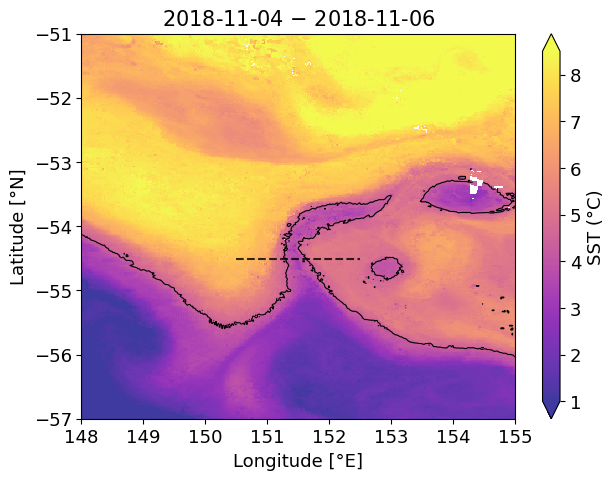

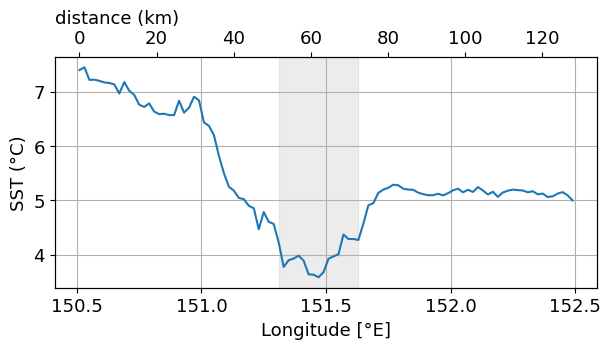

In [25]:
fig, ax = plt.subplots(figsize = (7,5))
mean_var.sel(latitude = slice(latmin, latmax), longitude = slice(148,155)).plot(vmin = vmin, vmax = vmax, alpha = 0.8, 
                                                                                cmap = cmap, cbar_kwargs = dict(label = label))

mean_var.sel(latitude = slice(latmin, latmax), longitude = slice(148,155)).plot.contour(colors = 'k',
                                                                        linewidths =0.8, levels = np.arange(4.4, 4.5, 0.1))


# plt.plot([151.2, 151.55], [lt, lt], c = 'silver', linewidth = 4)
plt.plot([150.5, 152.5], [lt, lt], c = 'k', linestyle = '--', alpha = 0.8)

ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
ax.set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')
ax.set_title(start_time + u' $-$ ' + end_time, fontsize = 15)

# settings.save_figure(fig, my_path, 'SST_filament.png', dpi = 600, pad = 0.2)

lons = mean_var.sel(latitude = lt, longitude = slice(150.5, 152.5)).longitude
lats = xr.DataArray(np.tile(lons.latitude, len(lons)))
dist = calc.cum_dist(lons, lats)


fig, ax = plt.subplots(figsize = (7,3))
mean_var.sel(latitude = lt, longitude = slice(150.5, 152.5)).plot()
ax.set_xticks(np.arange(150.5, 153, 0.5))
ax.axvspan(xmin = 151.31, xmax = 151.63, color = 'grey', alpha = 0.15)
ax.set_yticks(np.arange(4, 8, 1))

ax2 = ax.twiny()
ax2.plot(dist.data, mean_var.sel(latitude = lt, longitude = slice(150.5, 152.5)).data, alpha = 0)
ax2.set_xlabel('distance (km)', loc = 'left')
ax.grid()
ax.set_title('')
ax.set_ylabel(label)
ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')

# settings.save_figure(fig, my_path, 'SST_filament_scale.png', dpi = 600, pad = 0.2)

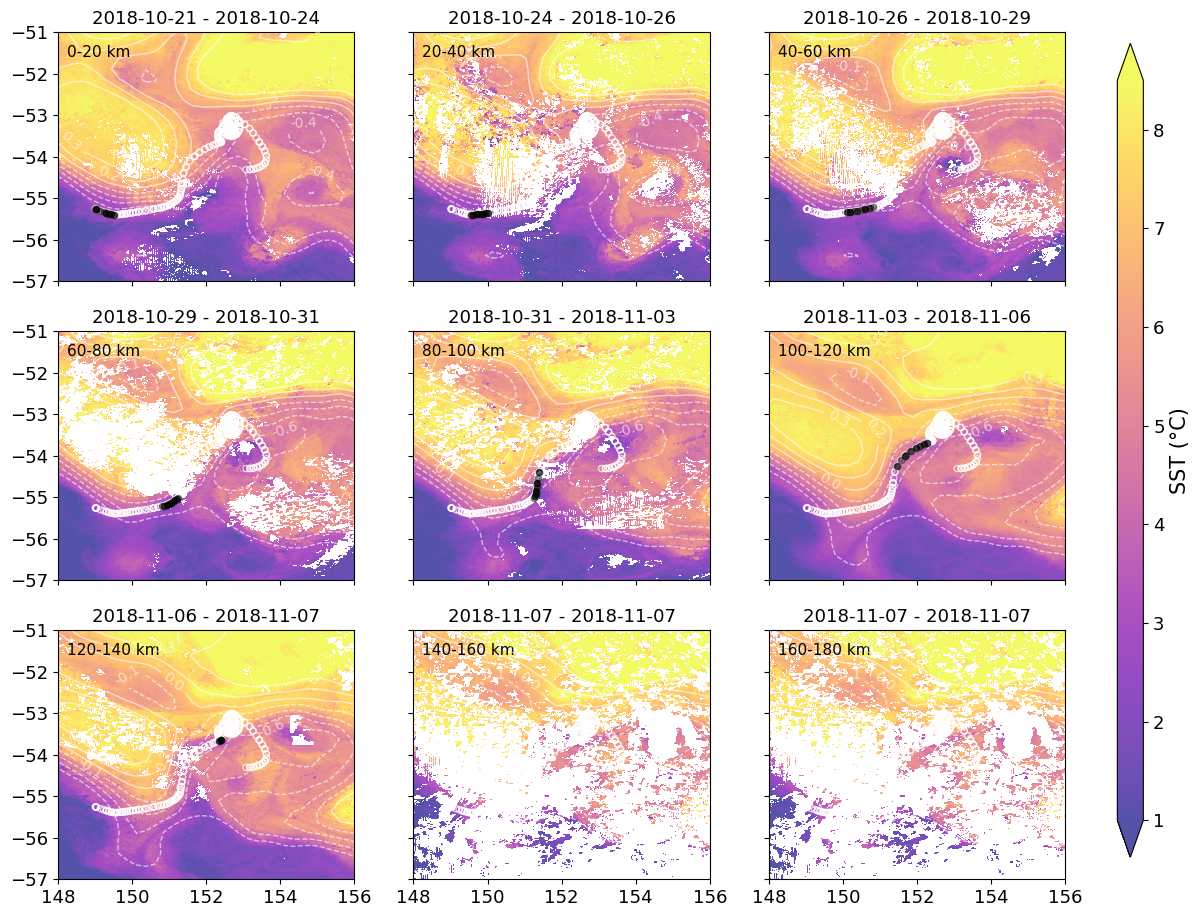

In [35]:
fig, axs = plt.subplots(nrows = 3, ncols=3, sharey = True, sharex = True, figsize = (13,11))
axs = axs.flatten()

d1 = 0
interval = 20 #in km along track

i = 0
for t in range(d1, d1 + interval*len(axs), interval):
    
    i_1 = stats.find_nearest(dist, t)[0]
    i_2 = stats.find_nearest(dist, t + interval)[0]
    
    start = float_num.time[i_1].values
    end = float_num.time[i_2].values
    start_time, end_time = str(start.astype('M8[D]')),  str(end.astype('M8[D]'))
    
    mean_field = var.sel(time = slice(start_time, end_time), 
                         latitude = lats, longitude = lons).mean(dim = 'time')
    
    
    im = mean_field.plot(ax = axs[i], alpha = 0.7, cmap = cmap, vmin = vmin, vmax = vmax, add_colorbar = False)
    
    msl = alt_cmems.adt.sel(time = slice(start_time, end_time)).mean(dim = 'time')
    CS = msl.plot.contour(ax = axs[i], colors = 'w', linewidths = 1, levels = levels, alpha = 0.6)
    plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')
    
    axs[i].scatter(float_num.longitude[rs], float_num.latitude[rs], s = 20, facecolors='none', edgecolors='w', alpha = 0.7, zorder = 3)
    axs[i].scatter(float_num.longitude[i_1:i_2], float_num.latitude[i_1:i_2], s = 20, c = 'k', alpha = 0.4, zorder = 3)
    
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_title(start_time + ' - ' + end_time, fontsize = 13)
    axs[i].text(0.03, 0.9, f'{t}-{t+interval} km', transform = axs[i].transAxes, fontsize = 11, c = 'k')
    
    i += 1
    
cax = plt.axes([0.94, 0.13, 0.02, 0.74])
cbar = plt.colorbar(im, cax=cax, extend = extend)
cbar.set_label(label, fontsize = 15)

In [36]:
# var = EKE.sel(time = slice(start_time, end_time))
# vmin, vmax = 0, 0.4
# cmap = cmocean.cm.amp
# label = 'EKE ($m^{2}$ $s^{-2}$)'
# latmin, latmax = -56, -51
# lats = slice(latmin, latmax)
# extend = 'max'

# var = fsle.sel(time = slice(start_time, end_time))
# vmin, vmax = -0.45, 0
# cmap = 'RdYlBu'
# label = u'FSLE ($day^{-1}$)'
# extend = 'min'
# latmin, latmax = -56, -51
# lats = slice(latmin, latmax)
# extend = 'min'

# var = ow.sel(time = slice(start_time, end_time))
# vmin, vmax = -3e-11, 3e-11
# cmap = 'RdBu_r'
# label = u'Okubo-Weiss'
# extend = 'both'
# latmin, latmax = -56, -51
# lats = slice(latmin, latmax)
# extend = 'both'

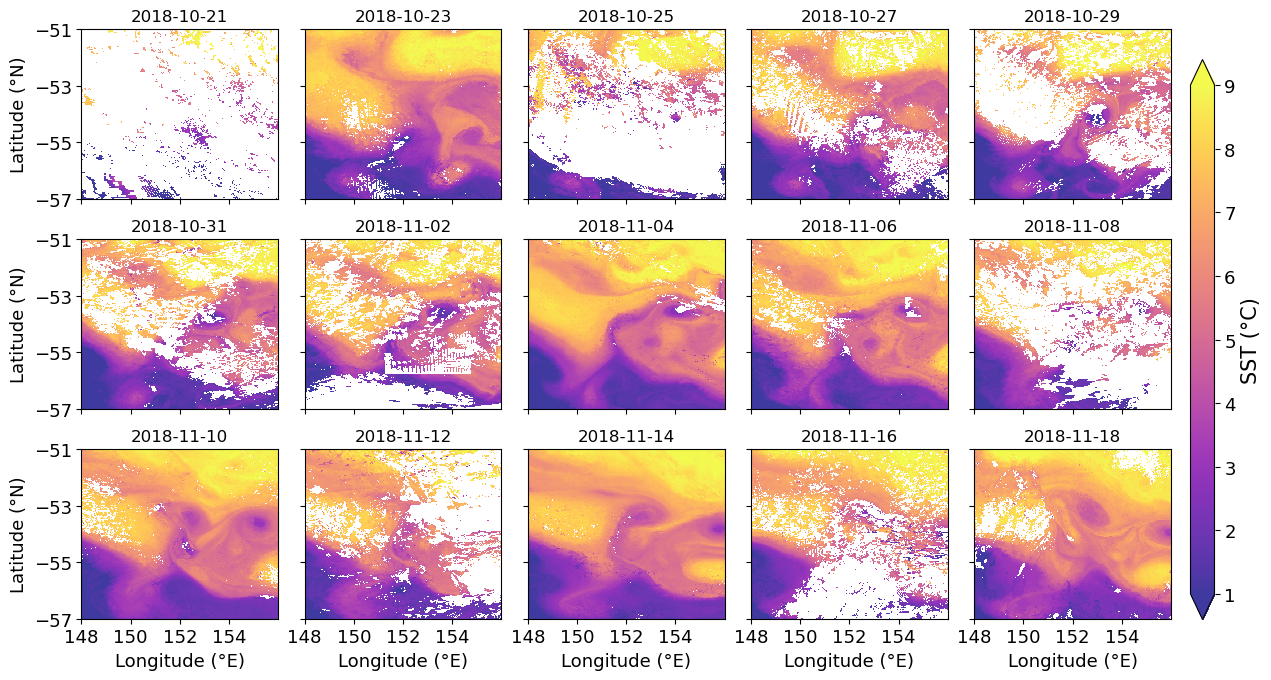

In [37]:
fig, axs = plt.subplots(nrows = 3, ncols = 5, sharey = True, sharex = True, figsize = (12,7))
axs = axs.flatten()

interval = 2

i = 0
for t in range(0+7, interval*len(axs)+7, interval):
    
    im = var.sel(latitude = lats, longitude = lons).isel(time = slice(t, t+interval)).mean(dim = 'time').plot(ax = axs[i], cmap = cmap, 
                                                                                            alpha = 0.8,vmin = vmin, vmax = 9, add_colorbar = False)
    
    ssh = adt.sel(latitude = slice(-57,-51), longitude = lons)
    msl = ssh.isel(time = slice(t, t+interval)).mean(dim = 'time')
    
#     CS = msl.plot.contour(ax = axs[i], colors = 'w', linewidths = 1, levels = levels, alpha = 0.6)
#     plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')
    
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_yticks(np.arange(latmax,latmin+1, 2))
    axs[i].set_xticks(np.arange(148,155, 2))

    axs[i].set_title(str(var[t].time.values.astype('M8[D]')),fontsize = 12)
    
#     axs[i].set_title(str(var[t].time.values.astype('M8[D]')) + ' - ' + str(var[t+interval].time.values.astype('M8[D]')), 
#                  fontsize = 12)
    
    if i in [0,5,10]:
        axs[i].set_ylabel('Latitude (°N)')
    if i in [10, 11, 12, 13, 14]:
        axs[i].set_xlabel('Longitude (°E)')

    i += 1
    
plt.tight_layout(w_pad = 0.5, h_pad = 0.5)

cax = plt.axes([1, 0.1, 0.02, 0.8])
cbar = plt.colorbar(im, cax=cax, extend = extend)
cbar.set_label(label, fontsize = 15)

In [44]:
# settings.save_figure(fig, my_path, 'SST_evolution.png', dpi = 300, pad = 0.2)

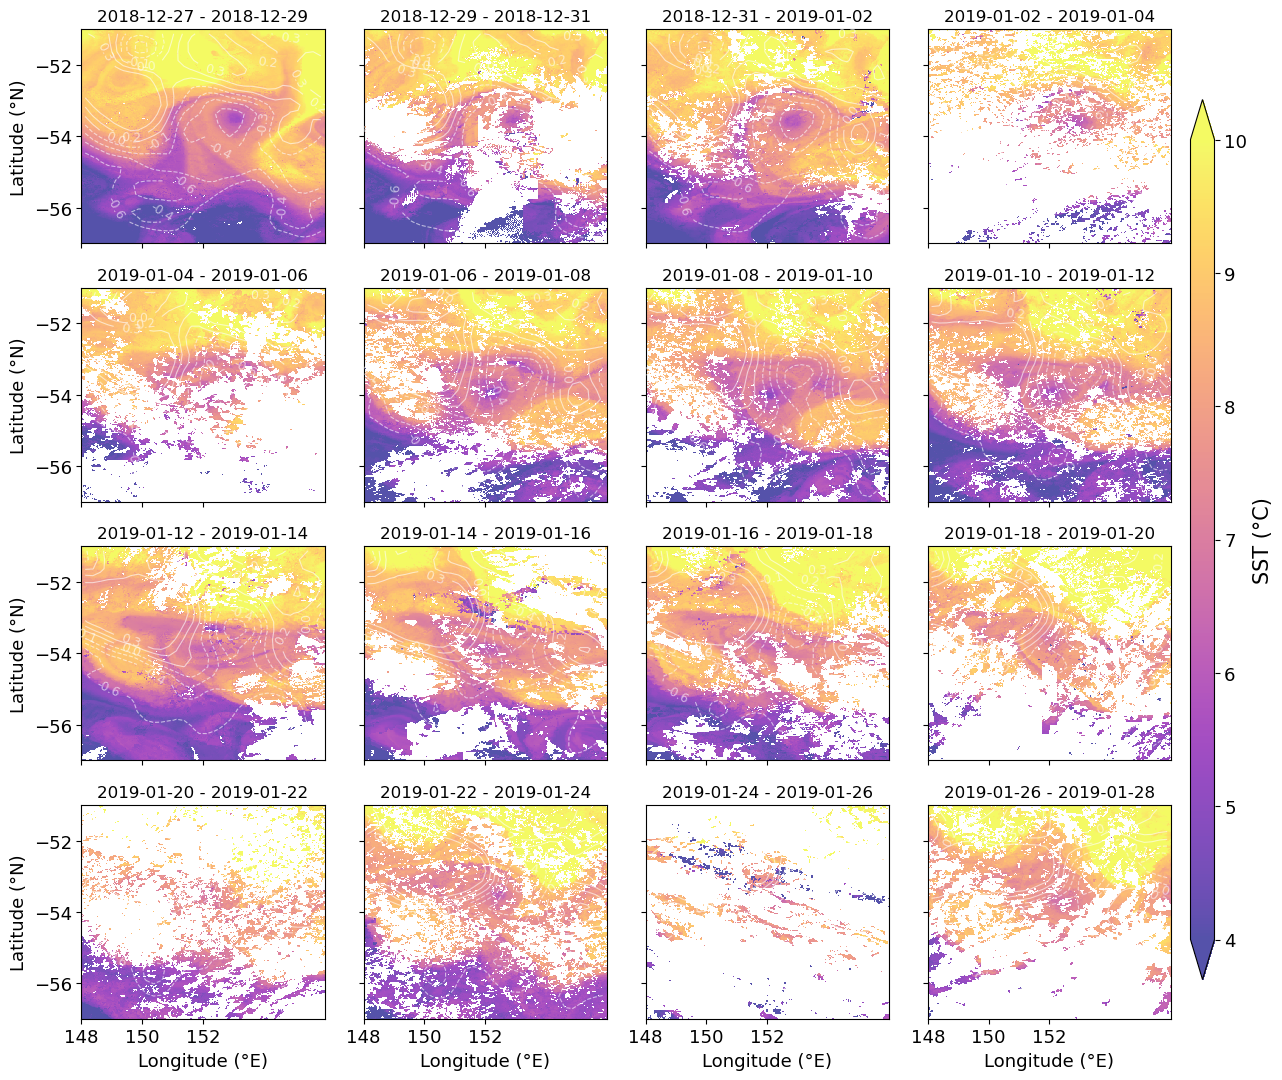

In [41]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, sharey = True, sharex = True, figsize = (12,11))
axs = axs.flatten()

ind0 = interval*len(axs)

i = 0
for t in range(ind0+42, ind0*2+42, interval):
    
    im = var.sel(latitude = lats, longitude = lons).isel(time = slice(t, t+interval)).mean(dim = 'time').plot(ax = axs[i], 
                                            alpha = 0.7, cmap = cmap, vmin = 4, vmax = 10, add_colorbar = False)
    
    ssh = alt_cmems.adt.sel(latitude = slice(-57,-51), longitude = lons)
    msl = ssh.isel(time = slice(t, t+interval)).mean(dim = 'time')
    
    CS = msl.plot.contour(ax = axs[i], colors = 'w', linewidths = 0.8, levels = levels, alpha = 0.6)
    plt.clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')
    
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_yticks(np.arange(-56,-51, 2))
    axs[i].set_xticks(np.arange(148,154, 2))

    axs[i].set_title(str(var[t].time.values.astype('M8[D]')) + ' - ' + str(var[t+interval].time.values.astype('M8[D]')), fontsize = 12)
    
    if i in [0,4,8, 12]:
        axs[i].set_ylabel('Latitude (°N)')
    if i in [12, 13, 14, 15]:
        axs[i].set_xlabel('Longitude (°E)')

    i += 1
    
plt.tight_layout(w_pad = 1.2)

cax = plt.axes([1, 0.1, 0.02, 0.8])
cbar = plt.colorbar(im, cax=cax, extend = extend)
cbar.set_label(label, fontsize = 15)